# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [48]:
import numpy as np
import emcee
import corner


/home/berres2002/miniconda3/envs/fds/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()

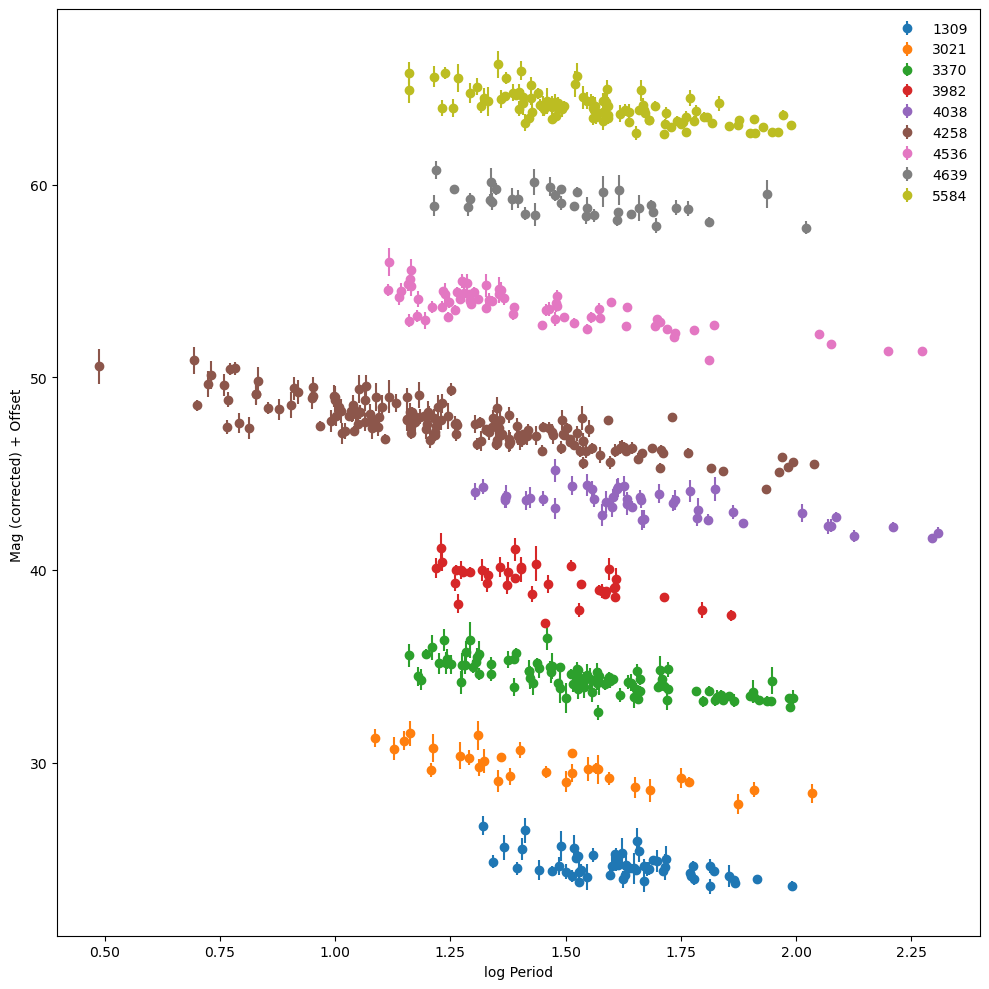

In [2]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

In [16]:
ceph.select(ceph.list_hosts()[0])
ceph.mobs

array([26.7371, 24.8681, 25.6012, 24.5263, 25.513 , 26.4842, 24.4343,
       24.384 , 24.6338, 25.6938, 24.35  , 24.1181, 25.5728, 25.0581,
       25.1307, 24.3153, 23.7843, 24.4089, 24.0502, 25.2102, 24.1851,
       24.6213, 25.2584, 24.9851, 24.669 , 25.2958, 23.9438, 24.1548,
       24.6115, 24.6615, 24.5543, 24.5168, 24.4348, 25.9261, 25.4302,
       24.64  , 23.8479, 24.4827, 24.4964, 24.9325, 24.8927, 24.3984,
       24.5884, 25.0118, 24.2861, 24.121 , 24.6163, 23.9628, 24.6279,
       23.5731, 24.3938, 24.1202, 23.9133, 23.7674, 23.971 , 23.5964])

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


---

The equation in question (Eq 1 from Riess et al. 2011),

$$ \large m_{W,i,j} = (\mu_{0,i} - \mu_{0,4258}) + z p_{W,4258} + b_W \log P_{i,j}$$

Where,

- $ m_{W,i,j}$ is the magnitude observed
- $(\mu_{0,i} - \mu_{0,4258})$ are the Reddening Free Distances for the hosts relative to NGC 4258 
- $z p_{W,4258}$ is the intercept of the P–L relation simultaneously fit to the Cepheids of NGC 4258 **DO WE CARE ABOUT THIS?**
    - The [P-L relation](https://en.wikipedia.org/wiki/Period-luminosity_relation)
- $b_W \log P_{i,j}$ is the nuisance parameter $b$ multiplied by the log of the period 

What is this???

```python
def negative_log_likelihood(self, theta):
        """
        Computes -log L(theta)

        Parameters
        ----------
        theta : float, ndarray
            parameters being fitted, (a,b)

        Returns
        -------
        0.5 * chisq
        """
        a, b = theta[0], theta[1]
        chisq = np.sum(((self.mobs - a * self.logP - b) / self.sigma)**2)
        return 0.5 * chisq
```

So it should be,

$$ \sum \left(\frac{m_\text{obs} - a \log P -b}{\sigma}\right)^2$$

Thus, where $n$ is the number of Cepheids ($j$) per $i^\text{th}$ Galaxy and $N$ is the number of galaxies,

$$-\chi^2 =\sum_{i=1}^{N} \sum_{j=1}^n \left(\frac{m_{W,i,j} - b_W \log P_{i,j} -((\mu_{0,i} - \mu_{0,4258}) + z p_{W,4258})}{\sigma_j}\right)^2$$

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

---
I don't know buddy... trying to figure out a prior for $\alpha$ where $\alpha = (\mu_{0,i} - \mu_{0,4258}) + z p_{W,4258}$

- 0.5 to 10

For $b_W$ we can assume a negative number via Homework #1 and magnitudes from -0.5 to -5

In [19]:
np.log10(49.97*1000/10)*5

18.493546747212935

In [34]:
np.log10(200/10)*5 -np.log10(10/10)*5

6.505149978319906

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [85]:
def logPrior(theta):
    re = []
    for i in range(len(theta)-1):
        if theta[i] >= 30 or theta[i]<=0.5:
            re.append(-np.inf)
        else:
            re.append(0)
    if theta[-1]<= -10 or theta[-1]>=-0.5:
        re.append(-np.inf)
    else:
        re.append(0)
    return np.sum(re)

def LogPosterior(theta):
    cs=[]
    for i, ID in enumerate(hosts):
        ceph.select(ID)
        wack = [theta[-1],theta[i]]
        cs.append(-ceph.negative_log_likelihood(wack))
    lnlike = np.sum(cs)
    lnprior=logPrior(theta)
    return lnlike+lnprior
    

In [87]:
ndim=len(hosts)+1
nwalkers=20
ig=np.zeros((nwalkers,len(hosts)+1))
ig[:,np.arange(len(hosts))]=np.random.uniform(0.5,30,(nwalkers,len(hosts)))
ig[:,-1] = np.random.uniform(-10,-0.5,(nwalkers))

In [88]:


sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior)
sampler.run_mcmc(ig,1000);

State([[23.85443362 19.99302004 25.57552015 22.78841946 19.70885597 22.1306018
  24.09946834 26.2193862  25.81741136 -0.53907452]
 [23.86284497 20.02178139 25.61981584 22.78324008 19.70762617 22.1221937
  24.07445703 26.22563928 25.8016322  -0.54069469]
 [23.85171378 19.99332376 25.52604522 22.79162008 19.75197054 22.09510422
  24.1724594  26.28537035 25.82249702 -0.53444479]
 [23.85500233 19.96506793 25.61638187 22.81176939 19.71047372 22.16013956
  24.05123977 26.22882921 25.81818151 -0.5405673 ]
 [23.89259114 19.92804802 25.55682214 22.80385499 19.74478648 22.15643579
  24.10128306 26.29801138 25.84114035 -0.53700503]
 [23.82703282 19.89843277 25.56354202 22.86223891 19.79688066 22.13406081
  24.10514966 26.28357656 25.85674051 -0.53515486]
 [23.76261061 19.93764819 25.55385015 22.86321119 19.7791037  22.12551115
  24.11684528 26.09676557 25.88414373 -0.533973  ]
 [23.89391925 19.92156813 25.56902015 22.81075524 19.76690076 22.138751
  24.08567859 26.27809666 25.85432502 -0.53807068

In [89]:
sam=sampler.get_chain(flat=True)

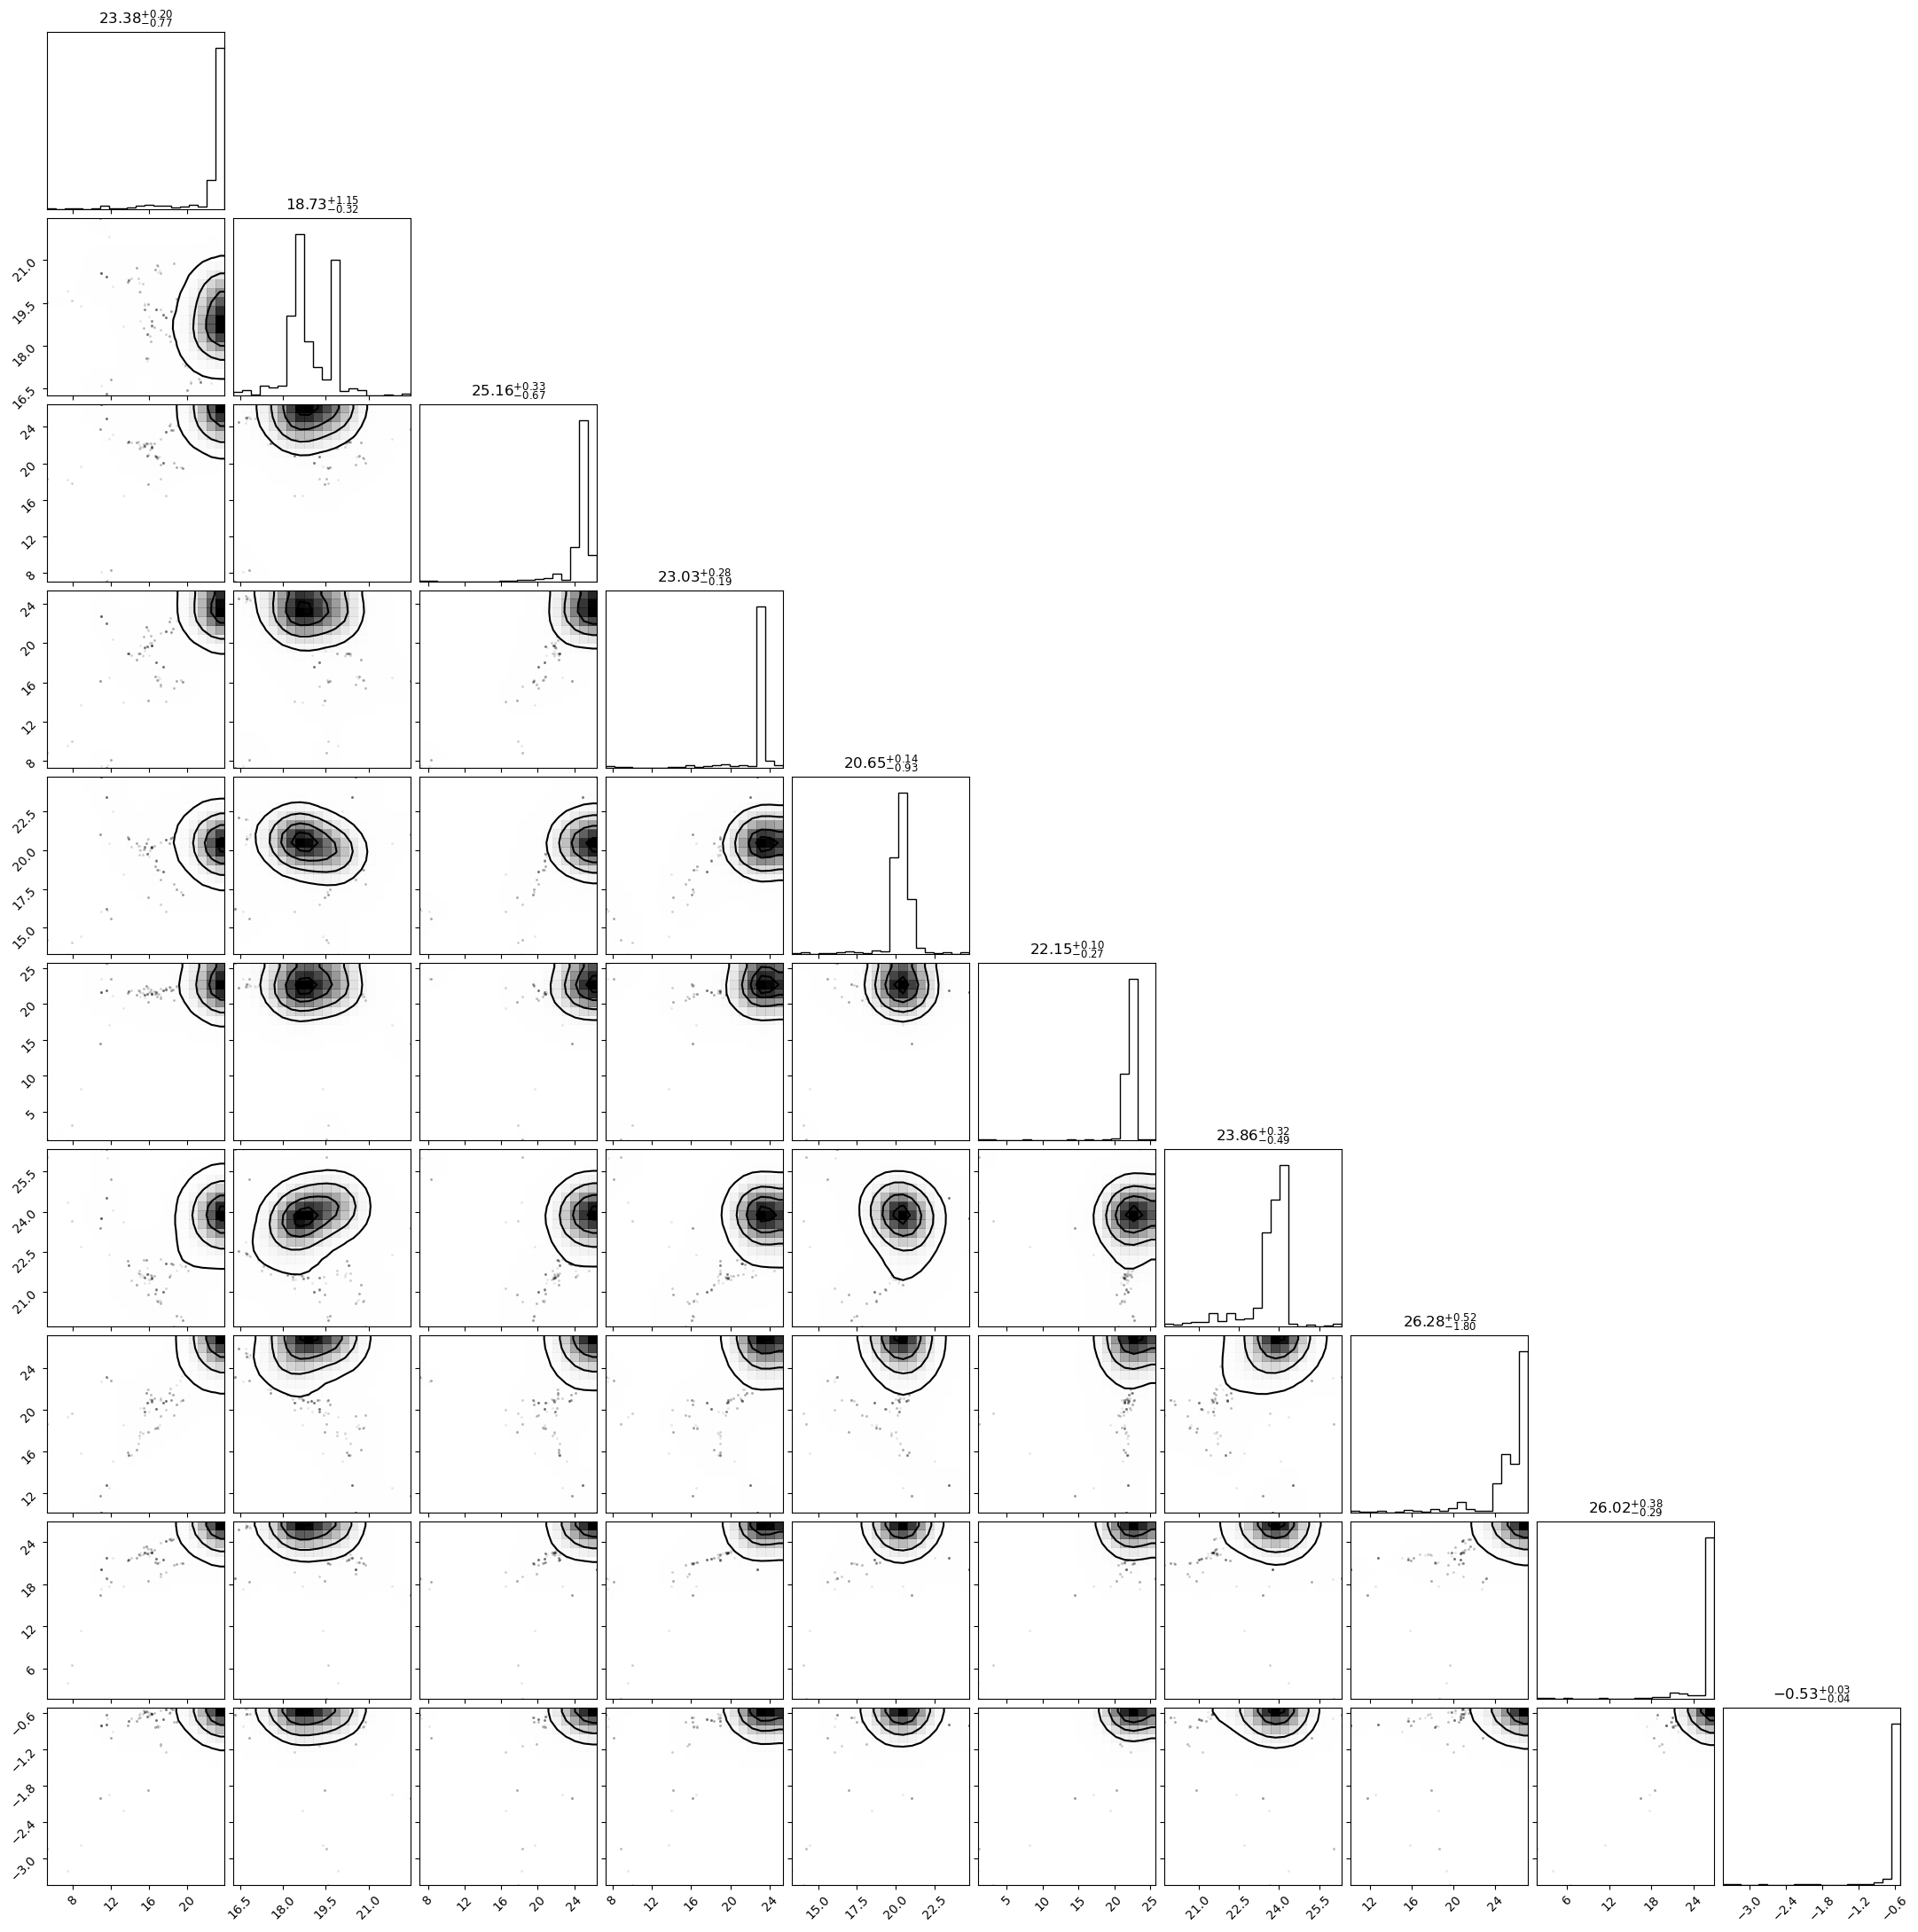

In [91]:
corner.corner(sam[::10], plot_contours=True, show_titles=True, smooth=2);

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.